# [keras-yolo3](https://github.com/qqwweee/keras-yolo3)

### 1. Download YOLOv3 weight from [YOLO website](http://pjreddie.com/darknet/yolo/)

In [1]:
wget https://pjreddie.com/media/files/yolov3.weights

Untitled.ipynb  yolov3.weights


### 2. Convert the Darknet YOLO model to a Keras model
- Need below three file to convert
 - convert.py, yolov3.cfg (exists in keras-yolo3)
 - yolov3.weights (downloaded)

In [1]:
!python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolo-tiny.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
W0702 16:39:38.338524 4489209280 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 16:39:38.357151 4489209280 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)
W0702 16:39:38.363806 4489209280 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 16:39:38.376152 4489209280 depre

Saved Keras model to model_data/yolo-tiny.h5
Read 8858734 of 8858734.0 from Darknet weights.


### 3. Object detection

In [2]:
from IPython.display import display 
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path)

    # 이미지 로딩
    image = Image.open(file)
    model = yolo.get_model()
    model.summary()

    # 실행
    result_image = yolo.detect_image(image)

    # 실행 결과 표시
    display(result_image)

Using TensorFlow backend.


In [3]:
objectDetection('data/light/images_test/IMG_3083.JPG', 'model_data/yolo.h5', 'model_data/coco_classes.txt')

W0702 16:40:11.137768 4513113536 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 16:40:11.138460 4513113536 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0702 16:40:11.138949 4513113536 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0702 16:40:11.151574 4513113536 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variab

num_anchors 9
num_classes 80


W0702 16:40:11.806813 4513113536 deprecation_wrapper.py:119] From /Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



AssertionError: Mismatch between model and given anchor and class sizes

# YOLO Custom data training

### 1. Convert VOC dataset to YOLO annotation
- copy and modified from voc_annotation.py

In [15]:
# Get class list
def load_classes():
    with open('./data/light/classes.txt') as f:
        classes = f.read().splitlines()
    return classes

classes = load_classes()
print(classes)

['bulb']


In [16]:
# Get annotations_voc list
import glob

annotations_voc = glob.glob('./data/light/annotations_voc/*.xml')
print(annotations_voc)

['./data/light/annotations_voc/IMG_3079.xml', './data/light/annotations_voc/IMG_3078.xml', './data/light/annotations_voc/IMG_3080.xml', './data/light/annotations_voc/IMG_3081.xml', './data/light/annotations_voc/IMG_3068.xml', './data/light/annotations_voc/IMG_3082.xml', './data/light/annotations_voc/IMG_3069.xml', './data/light/annotations_voc/IMG_3070.xml', './data/light/annotations_voc/IMG_3071.xml', './data/light/annotations_voc/IMG_3073.xml', './data/light/annotations_voc/IMG_3067.xml', './data/light/annotations_voc/IMG_3066.xml', './data/light/annotations_voc/IMG_3072.xml', './data/light/annotations_voc/IMG_3076.xml', './data/light/annotations_voc/IMG_3077.xml', './data/light/annotations_voc/IMG_3075.xml', './data/light/annotations_voc/IMG_3074.xml']


In [41]:
import xml.etree.ElementTree as ET
from os import getcwd

def convert_annotation(annotation_voc, converted_file):
    tree = ET.parse(annotation_voc)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        converted_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

converted_file = open('./data/light/annotations_yolo/train_all.txt', 'w')
for annotation_voc in annotations_voc:
    image_id = annotation_voc.split('/')[-1].split('.')[0]+'.JPG'
    converted_file.write('./data/light/images_train/%s'%(image_id))
    convert_annotation(annotation_voc, converted_file)
    converted_file.write('\n')
converted_file.close()

In [42]:
!cat data/light/annotations_yolo/train_all.txt

./data/light/images_train/IMG_3079.JPG 42,110,139,207,0
./data/light/images_train/IMG_3078.JPG 32,95,100,161,0
./data/light/images_train/IMG_3080.JPG 13,97,102,187,0
./data/light/images_train/IMG_3081.JPG 32,108,116,194,0
./data/light/images_train/IMG_3068.JPG 41,58,147,156,0
./data/light/images_train/IMG_3082.JPG 20,84,115,180,0
./data/light/images_train/IMG_3069.JPG 33,109,108,184,0
./data/light/images_train/IMG_3070.JPG 61,125,104,168,0
./data/light/images_train/IMG_3071.JPG 33,83,131,182,0
./data/light/images_train/IMG_3073.JPG 37,110,119,192,0
./data/light/images_train/IMG_3067.JPG 30,79,127,173,0
./data/light/images_train/IMG_3066.JPG 36,11,92,68,0
./data/light/images_train/IMG_3072.JPG 25,99,99,173,0
./data/light/images_train/IMG_3076.JPG 35,127,107,202,0
./data/light/images_train/IMG_3077.JPG 40,87,132,178,0
./data/light/images_train/IMG_3075.JPG 39,104,105,170,0
./data/light/images_train/IMG_3074.JPG 48,119,137,212,0


### 2. Retrain the YOLO model for custom dataset
- copy and modified from train.py

In [43]:
"""
Retrain the YOLO model for your own dataset.
"""

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data


def _main():
    annotation_path = 'data/light/annotations_yolo/train_all.txt'
    log_dir = 'logs/000/'
    classes_path = 'data/light/classes.txt'
    anchors_path = 'model_data/yolo_anchors.txt'
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape,
                                  anchors,
                                  num_classes,
                                  freeze_body=2,
                                  weights_path='model_data/yolo_tiny_light.h5')
    else:
        model = create_model(input_shape,
                             anchors,
                             num_classes,
                             freeze_body=2,
                             weights_path='model_data/yolo_light.h5')

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 32
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=50,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 32 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights model_data/yolo_light.h5.
Freeze the first 249 layers of total 252 layers.
Train on 16 samples, val on 1 samples, with batch size 32.
Epoch 1/50
1/1 [==============================] - 59s 59s/step - loss: 8227.0078 - val_loss: 7775.3330
Epoch 2/50
1/1 [==============================] - 39s 39s/step - loss: 7331.4106 - val_loss: 7183.2935
Epoch 3/50
1/1 [==============================] - 35s 35s/step - loss: 6475.1470 - val_loss: 6295.4082
Epoch 4/50
1/1 [==============================] - 33s 33s/step - loss: 5750.3042 - val_loss: 5686.7197
Epoch 5/50
1/1 [==============================] - 31s 31s/step - loss: 5107.3184 - val_loss: 5028.8486
Epoch 6/50
1/1 [==============================] - 30s 30s/step - loss: 4522.5703 - val_loss: 4233.7920
Epoch 7/50
1/1 [==============================] - 31s 31s/step - loss: 3989.7686 - val_loss: 3750.5732
Epoch 8/50
1/1 [==============================] - 33s 33s/step - loss: 3522.6758 -

Epoch 78/100
1/1 [==============================] - 119s 119s/step - loss: 42.8760 - val_loss: 51.7950
Epoch 79/100
1/1 [==============================] - 120s 120s/step - loss: 42.0486 - val_loss: 50.0721
Epoch 80/100
1/1 [==============================] - 116s 116s/step - loss: 41.3971 - val_loss: 49.2641
Epoch 81/100
1/1 [==============================] - 156s 156s/step - loss: 40.2925 - val_loss: 47.8666
Epoch 82/100
1/1 [==============================] - 195s 195s/step - loss: 40.8137 - val_loss: 46.4588
Epoch 83/100
1/1 [==============================] - 157s 157s/step - loss: 39.1697 - val_loss: 45.7756
Epoch 84/100
1/1 [==============================] - 167s 167s/step - loss: 38.6961 - val_loss: 44.9412
Epoch 85/100
1/1 [==============================] - 141s 141s/step - loss: 38.2743 - val_loss: 43.6516
Epoch 86/100
1/1 [==============================] - 150s 150s/step - loss: 37.5645 - val_loss: 42.9279
Epoch 87/100
1/1 [==============================] - 135s 135s/step - loss

### 3. Test

In [4]:
from IPython.display import display 
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path)
    model = yolo.get_model()
    model.summary()

    # 이미지 로딩
    image = Image.open(file)

    # 실행
    result_image = yolo.detect_image(image)

    # 실행 결과 표시
    display(result_image)

num_anchors 9
num_classes 1
logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
self.yolo_model.output [<tf.Tensor 'conv2d_134/BiasAdd:0' shape=(?, 13, 13, 18) dtype=float32>, <tf.Tensor 'conv2d_142/BiasAdd:0' shape=(?, 26, 26, 18) dtype=float32>, <tf.Tensor 'conv2d_150/BiasAdd:0' shape=(?, 52, 52, 18) dtype=float32>]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 416, 416, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 416, 416, 32) 128         con

shape
out_boxes (1, 4) [[534.97015 211.76901 818.902   487.55435]]
out_scores (1,) [0.9536172]
out_classes (1,) [0]
Found 1 boxes for img
bulb 0.95 (212, 535) (488, 819)
1.7196970499999225


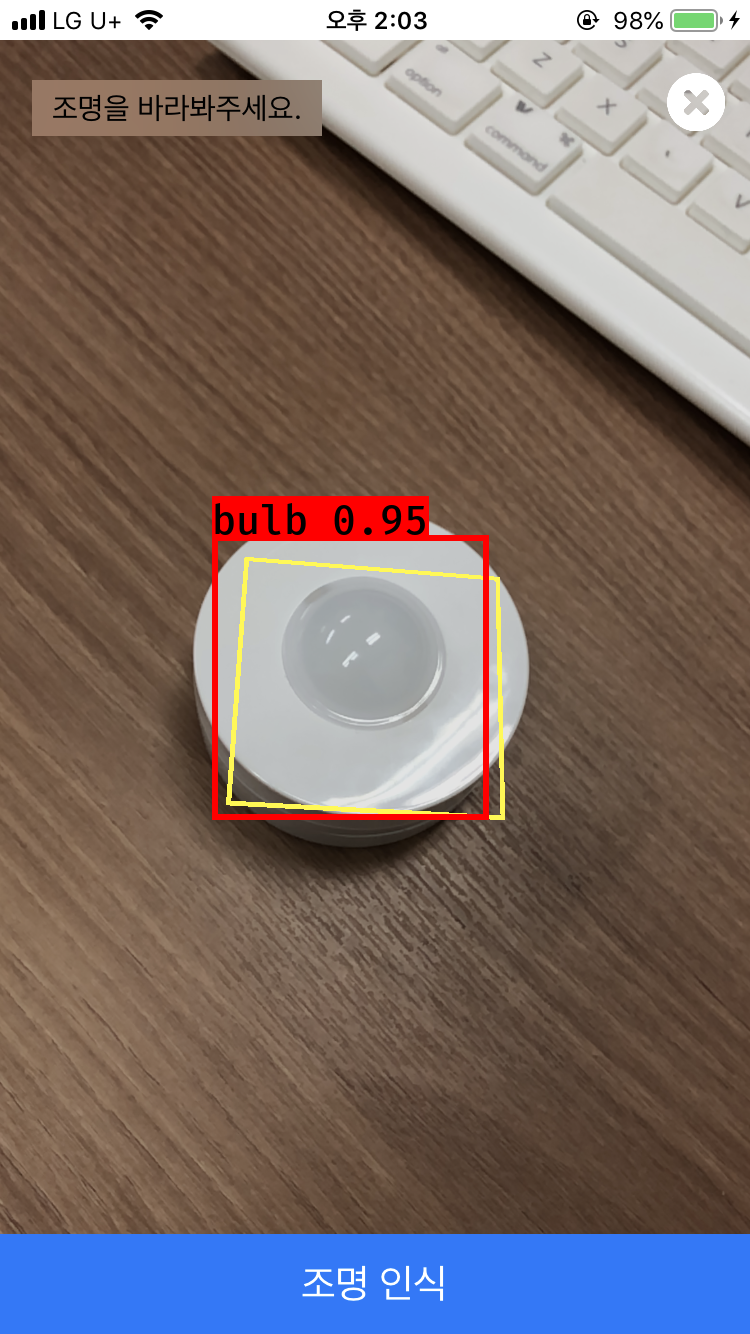

In [5]:
objectDetection('data/light/IMG_3178.PNG', 'logs/000/trained_weights_final.h5', 'data/light/classes.txt')

# Convert Keras h5 model to CoreML mlmodel
- [How to load yolo model](https://github.com/qqwweee/keras-yolo3/issues/48)

In [11]:
from yolo import YOLO
yolo = YOLO(model_path='data/light/trained_weights_final.h5', classes_path='data/light/classes.txt')
model = yolo.get_model()
model.save('data/light/LightModel.h5')

num_anchors 9
num_classes 1
data/light/trained_weights_final.h5 model, anchors, and classes loaded.
self.yolo_model.output [<tf.Tensor 'conv2d_284/BiasAdd:0' shape=(?, 13, 13, 18) dtype=float32>, <tf.Tensor 'conv2d_292/BiasAdd:0' shape=(?, 26, 26, 18) dtype=float32>, <tf.Tensor 'conv2d_300/BiasAdd:0' shape=(?, 52, 52, 18) dtype=float32>]


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d_226 (Conv2D)             (None, 416, 416, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 416, 416, 32) 128         conv2d_226[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_217 (LeakyReLU)     (None, 416, 416, 32) 0           batch_normalization_217[0][0]    
__________________________________________________________________________________________________
zero_paddi

In [ ]:
import coremltools
def getClasses(classes_path):
    with open(classes_path) as f:
        classes = f.read().splitlines()
    return classes

coreml_model = coremltools.converters.keras.convert('data/light/LightModel.h5',
                                                    image_input_names='image',
                                                    input_names="image",
                                                    output_names=['grid'],
                                                    image_scale=1/255.0)
coreml_model.author = 'nero'
coreml_model.short_description = 'Light Recognition Model'
coreml_model.input_description['image'] = 'Takes as input an image of a light'
coreml_model.output_description['grid'] = 'The 52 * 52 grid with the bounding box data'
coreml_model.save('data/light/LightModel2.mlmodel')

/Users/apple/.virtualenvs/ml/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Output name length mismatch
0 : input_4, <keras.engine.input_layer.InputLayer object at 0x1649c9780>
1 : conv2d_226, <keras.layers.convolutional.Conv2D object at 0x1649c97f0>
2 : batch_normalization_217, <keras.layers.normalization.BatchNormalization object at 0x1649c99e8>
3 : leaky_re_lu_217, <keras.layers.advanced_activations.LeakyReLU object at 0x1649c9a20>
4 : zero_padding2d_16, <keras.layers.convolutional.ZeroPadding2D object at 0x1649c9ba8>
5 : conv2d_227, <keras.layers.convolutional.Conv2D object at 0x1649c9be0>
6 : batch_normalization_218, <keras.layers.normalization.BatchNormalization object at 0x1649c9c18>
7 : leaky_re_lu_218, <keras.layers.advanced_activations.LeakyReLU object at 0x1649c9d68>
8 : conv2d_228, <keras.layers.convolutional.Conv2D object at 0x1649c9e80>
9 : batch_normalization_219, <keras.layers.normalization.BatchNormalization object at 0x1c16540b8>
10 : leaky_re_lu_219, <keras.layers.advanced_activations.LeakyReLU object at 0x1c16541d0>
11 : conv2d_229, <keras.

98 : batch_normalization_244, <keras.layers.normalization.BatchNormalization object at 0x1c167b198>
99 : leaky_re_lu_244, <keras.layers.advanced_activations.LeakyReLU object at 0x1c167b2b0>
100 : conv2d_254, <keras.layers.convolutional.Conv2D object at 0x1c167b2e8>
101 : batch_normalization_245, <keras.layers.normalization.BatchNormalization object at 0x1c167b4a8>
102 : leaky_re_lu_245, <keras.layers.advanced_activations.LeakyReLU object at 0x1c167b5c0>
103 : add_81, <keras.layers.merge.Add object at 0x1c167b5f8>
104 : conv2d_255, <keras.layers.convolutional.Conv2D object at 0x1c167b630>
105 : batch_normalization_246, <keras.layers.normalization.BatchNormalization object at 0x1c167b7f0>
106 : leaky_re_lu_246, <keras.layers.advanced_activations.LeakyReLU object at 0x1c167b908>
107 : conv2d_256, <keras.layers.convolutional.Conv2D object at 0x1c167b940>
108 : batch_normalization_247, <keras.layers.normalization.BatchNormalization object at 0x1c167bb00>
109 : leaky_re_lu_247, <keras.layers

195 : batch_normalization_272, <keras.layers.normalization.BatchNormalization object at 0x1c169db70>
196 : leaky_re_lu_272, <keras.layers.advanced_activations.LeakyReLU object at 0x1c169dc88>
197 : conv2d_282, <keras.layers.convolutional.Conv2D object at 0x1c169dcc0>
198 : batch_normalization_273, <keras.layers.normalization.BatchNormalization object at 0x1c169de80>
199 : leaky_re_lu_273, <keras.layers.advanced_activations.LeakyReLU object at 0x1c169df98>
200 : conv2d_285, <keras.layers.convolutional.Conv2D object at 0x1c1695fd0>
201 : batch_normalization_275, <keras.layers.normalization.BatchNormalization object at 0x1c16a81d0>
202 : leaky_re_lu_275, <keras.layers.advanced_activations.LeakyReLU object at 0x1c16a82e8>
203 : up_sampling2d_7, <keras.layers.convolutional.UpSampling2D object at 0x1c16a8320>
204 : concatenate_7, <keras.layers.merge.Concatenate object at 0x1c16a8358>
205 : conv2d_286, <keras.layers.convolutional.Conv2D object at 0x1c16a8390>
206 : batch_normalization_276, <k

In [14]:
import numpy as np
import PIL
from PIL import Image
import coremltools
import matplotlib.pyplot as plt
%matplotlib inline

def testMLModel(file, model_path):
    lightModel = coremltools.models.MLModel(model_path)

    # 이미지 로딩
    image = Image.open(file)

    # Error : https://github.com/apple/coremltools/issues/317
    # Unable to load CoreML.framework. Cannot make predictions.
    result_image = lightModel.predict({'image': image})

    # 실행 결과 표시
    print(result_image)

In [15]:
testMLModel('data/light/images_test/IMG_3169.JPG', 'data/light/LightModel.mlmodel')

Exception: Unable to load CoreML.framework. Cannot make predictions.